# Session 4 —  Dostoevsky Character Analysis with NLP
## Measure 6: Character Graph emotion analysis



In this notebook we:
- Load and clean full texts of *Crime and Punishment* and *The Brothers Karamazov*.
- Use a character library of names and aliases to extract sentences mentioning each major character.
- Apply sentence embeddings (via `sentence-transformers`) and clustering (via `KMeans`) to group themes such as fear, regret, and personality traits.
- Run emotion classification (via Hugging Face `twitter-roberta-base-emotion`) to quantify feelings like joy, sadness, anger, and fear.
- Print emotion counts for each character to understand their psychological profile.
- Visualize results with `matplotlib` as grouped bar charts, showing how emotions are distributed across characters.

This workflow allows us to build interpretable profiles of Dostoevsky’s characters, highlighting their inner struggles and emotional landscapes.


In [2]:
import re
from typing import List, Dict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
def load_book(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

CP_text = load_book('../data/Crime-punishment.txt')
BK_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"CP characters: {len(CP_text):,}")
print(f"BK characters: {len(BK_text):,}")


c:\Users\dimas\NLP_w2\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CP characters: 1,224,428
BK characters: 1,956,237


In [3]:
from character_library import CHARACTERS
from sklearn.cluster import KMeans
def split_sentences(text: str) -> List[str]:
    return re.split(r'(?<=[.!?]) +', text)
def get_character_sentences(text: str, aliases: List[str]) -> List[str]:
    sentences = split_sentences(text)
    results = []
    for s in sentences:
        for alias in aliases:
            if re.search(rf'\b{alias}\b', s, re.IGNORECASE):
                results.append(s)
                break
    return results
rask_sentences = get_character_sentences(CP_text, CHARACTERS["crime_and_punishment"]["Raskolnikov"])
print(len(rask_sentences), "sentences mentioning Raskolnikov")
embeddings = model.encode(rask_sentences)
labels = KMeans(n_clusters=5, random_state=42).fit_predict(embeddings)

921 sentences mentioning Raskolnikov


In [12]:
from character_library import CHARACTERS
from sklearn.cluster import KMeans
import re
from typing import List

def split_sentences(text: str) -> List[str]:
    return re.split(r'(?<=[.!?]) +', text)

def get_character_sentences(text: str, aliases: List[str]) -> List[str]:
    sentences = split_sentences(text)
    results = []
    for s in sentences:
        for alias in aliases:
            if re.search(rf'\b{alias}\b', s, re.IGNORECASE):
                results.append(s)
                break
    return results

# --- Extract Dmitri sentences ---
dmitri_aliases = CHARACTERS["brothers_karamazov"]["Dmitri"]

dmitri_sentences = get_character_sentences(
    BK_text,   # <-- your Brothers Karamazov text variable
    dmitri_aliases
)

print(len(dmitri_sentences), "sentences mentioning Dmitri")

# --- Embeddings ---
embeddings = model.encode(dmitri_sentences)

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(embeddings)

print(labels[:20])  # preview first 20 cluster labels


1142 sentences mentioning Dmitri
[2 0 0 3 3 3 3 3 3 3 3 3 3 0 2 1 2 2 2 2]


In [4]:
from character_library import CHARACTERS
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import re
from typing import List, Dict, Any
import numpy as np

# --- 1. Utility Functions ---

def split_sentences(text: str) -> List[str]:
    """Splits text into a list of sentences using common end-of-sentence punctuation."""
    # Note: Using '+' to handle multiple spaces after punctuation
    return re.split(r'(?<=[.!?]) +', text)

def get_character_sentences(text: str, aliases: List[str]) -> List[str]:
    """Extracts sentences that mention any of the provided character aliases."""
    sentences = split_sentences(text)
    results = []
    # Create a single, case-insensitive regex pattern for all aliases
    # \b ensures we match whole words (e.g., 'dmitri' but not 'dmitriev')
    alias_pattern = r'\b(' + '|'.join(re.escape(alias) for alias in aliases) + r')\b'

    for s in sentences:
        if re.search(alias_pattern, s, re.IGNORECASE):
            results.append(s.strip()) # strip whitespace for clean output
    return results

def get_centroid_sentences(
    sentences: List[str], embeddings: np.ndarray, labels: np.ndarray, n_clusters: int
) -> Dict[int, str]:
    """
    Identifies the sentence closest to the centroid of each cluster.
    This sentence serves as the best thematic example for that cluster.
    """
    centroid_sentences = {}
    for i in range(n_clusters):
        # 1. Get indices and embeddings for the current cluster
        cluster_indices = np.where(labels == i)[0]
        cluster_embeddings = embeddings[cluster_indices]
        
        if len(cluster_embeddings) == 0:
            centroid_sentences[i] = "Cluster empty."
            continue

        # 2. Get the centroid of the current cluster
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # 3. Calculate distance from every sentence in the cluster to the centroid
        # Reshape centroid for correct distance calculation
        distances = euclidean_distances(cluster_embeddings, centroid.reshape(1, -1))
        
        # 4. Find the index of the sentence with the minimum distance (closest to centroid)
        closest_index_in_cluster = np.argmin(distances)
        
        # 5. Map back to the original sentence list index
        original_sentence_index = cluster_indices[closest_index_in_cluster]
        
        # 6. Store the representative sentence
        centroid_sentences[i] = sentences[original_sentence_index]
        
    return centroid_sentences

# --- 2. Setup (ASSUMED VARIABLES: BK_text, model, CHARACTERS) ---

# --- ASSUMED: The text of The Brothers Karamazov ---
# BK_text = "..." 

# --- ASSUMED: The pre-loaded sentence embedding model ---
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-MiniLM-L6-v2') 

# --- 3. Execution ---

# Extract aliases for Dmitri
dmitri_aliases = CHARACTERS["brothers_karamazov"]["Dmitri"]

# Extract all sentences mentioning Dmitri
dmitri_sentences = get_character_sentences(
    BK_text, 
    dmitri_aliases
)

print(f"--- Extraction Results ---")
print(f"{len(dmitri_sentences)} sentences mentioning Dmitri")

# Embeddings: Convert sentences to numerical vectors
embeddings = model.encode(dmitri_sentences, show_progress_bar=False)

# KMeans clustering: Group into 5 topics
N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

print(f"\n--- Clustering Preview (First 20 Labels) ---")
print(labels[:20])

# --- 4. Analysis and Output ---

# Find the representative sentence for each of the 5 clusters
centroid_sentences_by_cluster = get_centroid_sentences(
    dmitri_sentences, 
    embeddings, 
    labels, 
    N_CLUSTERS
)

print(f"\n--- 5 Thematic Clusters for Dmitri Karamazov ---")
for cluster, sentence in centroid_sentences_by_cluster.items():
    count = np.sum(labels == cluster)
    print(f"\n### Cluster {cluster} ({count} sentences)")
    print(f"> Representative Sentence (Closest to Center): \"{sentence}\"")

--- Extraction Results ---
1142 sentences mentioning Dmitri

--- Clustering Preview (First 20 Labels) ---
[2 0 0 3 3 3 3 3 3 3 3 3 3 0 2 1 2 2 2 2]

--- 5 Thematic Clusters for Dmitri Karamazov ---

### Cluster 0 (271 sentences)
> Representative Sentence (Closest to Center): "There was a wave of sympathy for Mitya."

### Cluster 1 (152 sentences)
> Representative Sentence (Closest to Center): "There’s not a doubt you did reckon on Dmitri Fyodorovitch.”

			“What I put up with from you!"

### Cluster 2 (187 sentences)
> Representative Sentence (Closest to Center): "Damn him, I certainly did want to see Dmitri, but now there’s no need,” said Ivan reluctantly.

			“But are you really going so soon, brother?”

			“Yes.”

			“What of Dmitri and father?"

### Cluster 3 (199 sentences)
> Representative Sentence (Closest to Center): "What, you want to write that down, too?” he cried in dismay.

			“Yes, what you said just now,” said Nikolay Parfenovitch, looking at him in surprise, “that is, t

In [ ]:
from character_library import CHARACTERS
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import re
from typing import List, Dict, Any
import numpy as np

# --- 1. Utility Functions ---

def split_sentences(text: str) -> List[str]:
    """Splits text into a list of sentences using common end-of-sentence punctuation."""
    # Note: Using '+' to handle multiple spaces after punctuation
    return re.split(r'(?<=[.!?]) +', text)

def get_character_sentences(text: str, aliases: List[str]) -> List[str]:
    """Extracts sentences that mention any of the provided character aliases."""
    sentences = split_sentences(text)
    results = []
    # Create a single, case-insensitive regex pattern for all aliases
    # \b ensures we match whole words (e.g., 'dmitri' but not 'dmitriev')
    alias_pattern = r'\b(' + '|'.join(re.escape(alias) for alias in aliases) + r')\b'

    for s in sentences:
        if re.search(alias_pattern, s, re.IGNORECASE):
            results.append(s.strip()) # strip whitespace for clean output
    return results

def get_centroid_sentences(
    sentences: List[str], embeddings: np.ndarray, labels: np.ndarray, n_clusters: int
) -> Dict[int, str]:
    """
    Identifies the sentence closest to the centroid of each cluster.
    This sentence serves as the best thematic example for that cluster.
    """
    centroid_sentences = {}
    for i in range(n_clusters):
        # 1. Get indices and embeddings for the current cluster
        cluster_indices = np.where(labels == i)[0]
        cluster_embeddings = embeddings[cluster_indices]
        
        if len(cluster_embeddings) == 0:
            centroid_sentences[i] = "Cluster empty."
            continue

        # 2. Get the centroid of the current cluster
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # 3. Calculate distance from every sentence in the cluster to the centroid
        # Reshape centroid for correct distance calculation
        distances = euclidean_distances(cluster_embeddings, centroid.reshape(1, -1))
        
        # 4. Find the index of the sentence with the minimum distance (closest to centroid)
        closest_index_in_cluster = np.argmin(distances)
        
        # 5. Map back to the original sentence list index
        original_sentence_index = cluster_indices[closest_index_in_cluster]
        
        # 6. Store the representative sentence
        centroid_sentences[i] = sentences[original_sentence_index]
        
    return centroid_sentences

# --- 2. Setup (ASSUMED VARIABLES: BK_text, model, CHARACTERS) ---

# --- ASSUMED: The text of The Brothers Karamazov ---
# BK_text = "..." 

# --- ASSUMED: The pre-loaded sentence embedding model ---
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-MiniLM-L6-v2') 

# --- 3. Execution ---

# Extract aliases for Dmitri
dmitri_aliases = CHARACTERS["brothers_karamazov"]["Dmitri"]

# Extract all sentences mentioning Dmitri
dmitri_sentences = get_character_sentences(
    BK_text, 
    dmitri_aliases
)

print(f"--- Extraction Results ---")
print(f"{len(dmitri_sentences)} sentences mentioning Dmitri")

# Embeddings: Convert sentences to numerical vectors
embeddings = model.encode(dmitri_sentences, show_progress_bar=False)

# KMeans clustering: Group into 5 topics
N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

print(f"\n--- Clustering Preview (First 20 Labels) ---")
print(labels[:20])

# --- 4. Analysis and Output ---

# Find the representative sentence for each of the 5 clusters
centroid_sentences_by_cluster = get_centroid_sentences(
    dmitri_sentences, 
    embeddings, 
    labels, 
    N_CLUSTERS
)

print(f"\n--- 5 Thematic Clusters for Dmitri Karamazov ---")
for cluster, sentence in centroid_sentences_by_cluster.items():
    count = np.sum(labels == cluster)
    print(f"\n### Cluster {cluster} ({count} sentences)")
    print(f"> Representative Sentence (Closest to Center): \"{sentence}\"")

In [6]:
from transformers import pipeline

# Load the emotion model
emotion_analyzer = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion",
    truncation=True,        # <-- important
    max_length=512          # <-- enforce max length
)

def analyze_emotions(sentences):
    emotions = []
    for s in sentences:
        # Truncate long sentences manually as a safeguard
        if len(s.split()) > 200:   # ~200 words ≈ 512 tokens
            s = " ".join(s.split()[:200])
        result = emotion_analyzer(s)[0]
        emotions.append(result['label'])
    return emotions

Device set to use cpu


In [7]:
from collections import Counter

def plot_character_emotions(character: str, sentences: List[str]):
    emotions = analyze_emotions(sentences)
    counts = Counter(emotions)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"Emotions for {character}")
    plt.show()

In [ ]:
'''from collections import Counter
import matplotlib.pyplot as plt

def summarize_character_emotions(book_text, character_name, aliases):
    # Extract sentences mentioning the character
    sentences = get_character_sentences(book_text, aliases)
    # Run emotion analysis
    emotions = analyze_emotions(sentences)
    # Count frequencies
    return Counter(emotions)

def analyze_and_visualize(book_text, character_dict, title="Character Profiles"):
    profiles = {}
    print("=== Emotion counts per character ===")
    for char, aliases in character_dict.items():
        counts = summarize_character_emotions(book_text, char, aliases)
        profiles[char] = counts
        print(f"{char}: {dict(counts)}")   # <-- print results here

    # Collect all possible emotion labels
    all_emotions = set()
    for counts in profiles.values():
        all_emotions.update(counts.keys())
    all_emotions = sorted(all_emotions)

    # Plot grouped bar chart
    x = range(len(all_emotions))
    width = 0.1
    plt.figure(figsize=(12,6))

    for i, (char, counts) in enumerate(profiles.items()):
        values = [counts.get(e, 0) for e in all_emotions]
        plt.bar([p + i*width for p in x], values, width=width, label=char)

    plt.xticks([p + width*len(profiles)/2 for p in x], all_emotions, rotation=45)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()'''

In [ ]:
#the previous function shows repeated colors for the charcters, making it hard to distinguish them in the bar chart.


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def summarize_character_emotions(book_text, character_name, aliases):
    # Extract sentences mentioning the character
    sentences = get_character_sentences(book_text, aliases)
    # Run emotion analysis
    emotions = analyze_emotions(sentences)
    # Count frequencies
    return Counter(emotions)
def analyze_and_visualize(book_text, character_dict, title="Character Profiles"):
    profiles = {}
    print("=== Emotion counts per character ===")
    for char, aliases in character_dict.items():
        counts = summarize_character_emotions(book_text, char, aliases)
        profiles[char] = counts
        print(f"{char}: {dict(counts)}")

    # Collect all possible emotion labels
    all_emotions = sorted({e for counts in profiles.values() for e in counts})

    x = np.arange(len(all_emotions))
    width = 0.8 / len(profiles)   # dynamic width based on number of characters

    # Generate distinct colors for each character
    colors = cm.get_cmap('tab10', len(profiles))

    plt.figure(figsize=(12, 6))

    for i, (char, counts) in enumerate(profiles.items()):
        values = [counts.get(e, 0) for e in all_emotions]
        plt.bar(
            x + i*width,
            values,
            width=width,
            label=char,
            color=colors(i)    # <-- Each character gets a single unique color
        )

    plt.xticks(x + width*(len(profiles)/2), all_emotions, rotation=45)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Emotion counts per character ===
Raskolnikov: {'joy': 242, 'sadness': 264, 'anger': 143, 'optimism': 272}
Sonia: {'anger': 41, 'sadness': 164, 'optimism': 74, 'joy': 74}
Marmeladov: {'joy': 11, 'sadness': 16, 'anger': 1, 'optimism': 15}
Katerina: {'sadness': 52, 'optimism': 54, 'joy': 56, 'anger': 19}
Dounia: {'anger': 75, 'joy': 92, 'sadness': 111, 'optimism': 95}
Razumihin: {'optimism': 97, 'sadness': 100, 'joy': 95, 'anger': 46}
Porfiry: {'sadness': 46, 'joy': 65, 'anger': 26, 'optimism': 46}
Svidrigailov: {}
Luzhin: {'optimism': 68, 'anger': 27, 'sadness': 46, 'joy': 89}
Pulcheria: {'sadness': 38, 'joy': 27, 'optimism': 38, 'anger': 15}
Lizaveta: {'optimism': 23, 'joy': 13, 'sadness': 16, 'anger': 2}
Alyona: {'joy': 11, 'anger': 2, 'optimism': 7, 'sadness': 5}
Zossimov: {'optimism': 27, 'sadness': 22, 'joy': 23, 'anger': 9}
Nikodim: {}


C:\Users\dimas\AppData\Local\Temp\ipykernel_13300\2654076587.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(profiles))


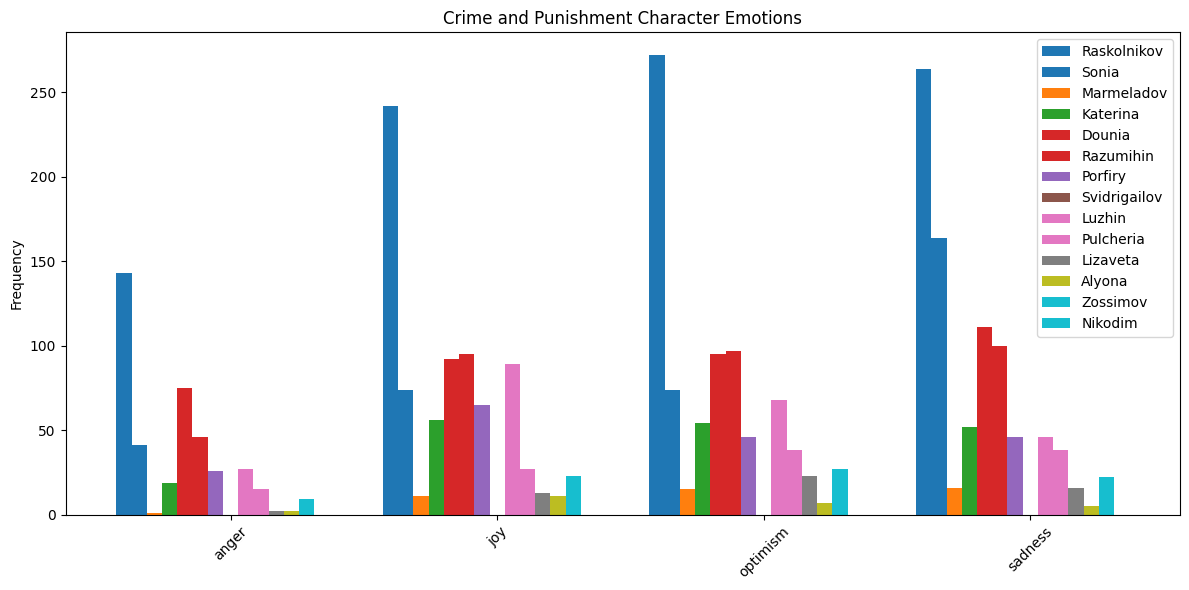

=== Emotion counts per character ===
Alyosha: {'optimism': 375, 'anger': 154, 'joy': 249, 'sadness': 332}
Ivan: {'anger': 103, 'optimism': 181, 'sadness': 177, 'joy': 191}
Dmitri: {'anger': 174, 'sadness': 265, 'optimism': 317, 'joy': 386}
Fyodor: {'sadness': 77, 'optimism': 84, 'joy': 95, 'anger': 31}
Grushenka: {'sadness': 78, 'joy': 120, 'optimism': 121, 'anger': 42}
Katerina: {'optimism': 78, 'anger': 27, 'sadness': 51, 'joy': 48}
Father Zosima: {}
Smerdyakov: {'joy': 126, 'optimism': 62, 'anger': 43, 'sadness': 104}
Rakitin: {'sadness': 36, 'joy': 71, 'optimism': 51, 'anger': 20}
Kolya: {}
Lise: {'optimism': 51, 'anger': 20, 'joy': 33, 'sadness': 37}
Madame Khokhlakov: {}
Ilusha: {'joy': 19, 'optimism': 62, 'sadness': 51, 'anger': 14}
Captain Sneigiryov: {}


C:\Users\dimas\AppData\Local\Temp\ipykernel_13300\2654076587.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(profiles))


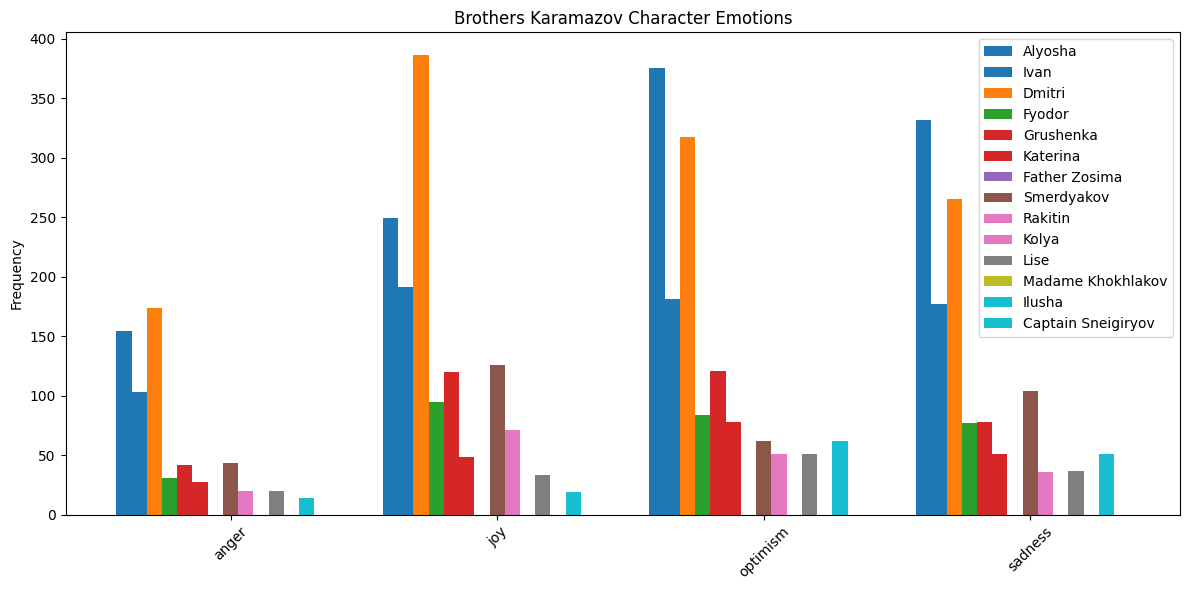

In [9]:
# Crime and Punishment
analyze_and_visualize(CP_text, CHARACTERS["crime_and_punishment"], 
                      title="Crime and Punishment Character Emotions")

# Brothers Karamazov
analyze_and_visualize(BK_text, CHARACTERS["brothers_karamazov"], 
                      title="Brothers Karamazov Character Emotions")

In [16]:
#ANGER ANALYSIS IS IT INTERNAL OR EXTERNAL?:

def classify_anger(sentences):
    internal_keywords =  {
        "myself","me","guilt","ashamed","regret","remorse","conscience","torment","suffering",
        "despair","misery","punishment","sin","crime","redemption","shame","weakness","cowardice",
        "self-loathing","madness","delirium","fever","dream","nightmare","soul","burden","curse","repent"
    }

    external_keywords =  {
        "you","him","her","father","mother","brother","sister","family","society","judge","police",
        "insult","quarrel","fight","enemy","hatred","contempt","scorn","injustice","betrayal",
        "accusation","blame","violence","murder","theft","greed","hypocrisy","corruption","oppression","tyranny"
    }


    internal, external = [], []

    for s in sentences:
        s_lower = s.lower()
        if any(word in s_lower for word in internal_keywords):
            internal.append(s)
        elif any(word in s_lower for word in external_keywords):
            external.append(s)
    return internal, external

def analyze_anger(book_text, character_name, aliases):
    # Extract sentences mentioning the character
    sentences = get_character_sentences(book_text, aliases)
    # Filter only those classified as anger
    emotions = analyze_emotions(sentences)
    anger_sentences = [s for s, e in zip(sentences, emotions) if e == "anger"]

    internal, external = classify_anger(anger_sentences)

    print(f"\n=== Anger Analysis for {character_name} ===")
    print(f"Internal anger: {len(internal)} examples")
    for ex in internal[:3]:   # show first 3 examples
        print(" -", ex.strip())

    print(f"External anger: {len(external)} examples")
    for ex in external[:3]:
        print(" -", ex.strip())

    return {"internal": internal, "external": external}

In [17]:
# Example for Raskolnikov
anger_profile = analyze_anger(CP_text, "Raskolnikov", CHARACTERS["crime_and_punishment"]["Raskolnikov"])


=== Anger Analysis for Raskolnikov ===
Internal anger: 91 examples
 - Finally, his meeting with the
saintly prostitute Sonia ultimately rescues him from
his own alter ego as she helps him to explore the path
that he must take to redemption.
    Perhaps most notable are the novel’s detailed
characters, including the evolution of the psychologi-
cal processes that occur in Raskolnikov’s criminal
mind.
 - While Raskolnikov’s narration is unreliable,


                          vii
                    introduction

the reactions of his friends and family not only help
to elucidate his character, but also the themes of
nihilism and existentialism.
    Rooted in the idea that people can develop a
utopia if they live for the purpose of enlightened self-
interest, nihilism is based on scientific fact and rea-
soning.
 - Like Raskolnikov, he torments him-
self to no end — similar to the existentialist role
model Sisyphus, who eternally rolls a boulder up a
hill, only to see it roll back down 

In [17]:
anger_profile = analyze_anger(BK_text, "Dmitri", CHARACTERS["brothers_karamazov"]["Dmitri"])


=== Anger Analysis for Dmitri ===
Internal anger: 103 examples
 - He regarded it as his duty as a citizen and a man of culture to open an attack upon the “clericals.” Hearing all about Adelaïda Ivanovna, whom he, of course, remembered, and in whom he had at one time been interested, and learning of the existence of Mitya, he intervened, in spite of all his youthful indignation and contempt for Fyodor Pavlovitch.
 - Mitya did, in fact, pass into this cousin’s keeping, but as the latter had no family of his own, and after securing the revenues of his estates was in haste to return at once to Paris, he left the boy in charge of one of his cousins, a lady living in Moscow.
 - I won’t enlarge upon that now, as I shall have much to tell later of Fyodor Pavlovitch’s firstborn, and must confine myself now to the most essential facts about him, without which I could not begin my story.

			In the first place, this Mitya, or rather Dmitri Fyodorovitch, was the only one of Fyodor Pavlovitch’s th